# TDMA in 1D

Tested in algorithm.f90


# Fully staggered mesh

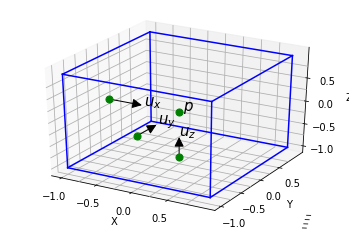

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.set_aspect("equal")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

major_ticks = np.arange(-1, 1, 0.5)
minor_ticks = np.arange(-1, 1, 0.25)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.set_zticks(major_ticks)
ax.set_zticks(minor_ticks, minor=True)


# draw cube
r = [-1, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="b")

# draw a point
ax.scatter([0], [0], [0], color="g", s=50)
ax.text(0, 0.1, 0, '$p$', fontsize=15)

# draw a vector
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

ax.scatter([-1], [0], [0], color="g", s=50)
a = Arrow3D([-1, -0.5], [0, 0], [0, 0], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.text(-0.5, 0, 0, '$u_x$', fontsize=15)
ax.add_artist(a)

ax.scatter([0], [-1], [0], color="g", s=50)
a = Arrow3D([0, 0], [-1, -0.5], [0, 0], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.text(0, -0.5, 0, '$u_y$', fontsize=15)
ax.add_artist(a)

ax.scatter([0], [0], [-1], color="g", s=50)
a = Arrow3D([0, 0], [0, 0], [-1, -0.5], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.text(0, 0, -0.5, '$u_z$', fontsize=15)
ax.add_artist(a)

plt.show()

# Interpolation
The input velocity is
$u(x,y,z)=sin(x) + sin(y) + sin(z)$. $x \in \{ 0, 2\pi \}$, $y \in \{ -\pi ,\pi \}$.

The interpolation involve two types of interpolation,
* interpolation of u in x direction, from face $(i', j, k)$ to cell centre $(i, j, k)$, called P2C
* interpolation of u in y direction, from face $(i', j, k)$ to edge $(i', j', k)$, called C2P

## Interpolation on uniform mesh with Periodic B.C.

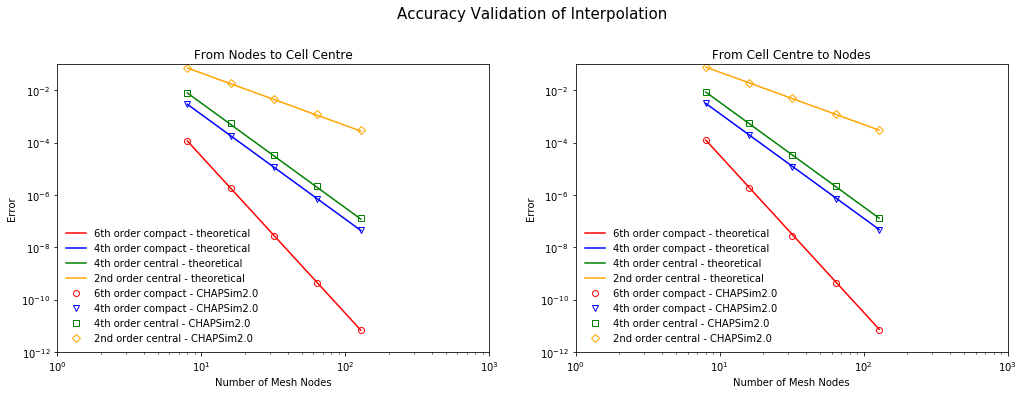

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red

nsz = np.array([8, 16, 32, 64, 128])

err6cp_p2c = np.array([1.1444298E-04, 1.7905790E-06, 2.7979968E-08, 4.3719028E-10, 6.8323125E-12])
err6cp_c2p = np.array([1.2387219E-04, 1.8256585E-06, 2.8115351E-08, 4.3771764E-10, 6.8349770E-12])

err4cp_p2c = np.array([2.8881061E-03, 1.8456799E-04, 1.1593294E-05, 7.2546235E-07, 4.5355088E-08])
err4cp_c2p = np.array([3.1260635E-03, 1.8818389E-04, 1.1649389E-05, 7.2633726E-07, 4.5368752E-08])

err4cd_p2c = np.array([7.8261419E-03, 5.3968797E-04, 3.4557253E-05, 2.1728943E-06, 1.3601063E-07])
err4cd_c2p = np.array([8.4709550E-03, 5.5026108E-04, 3.4724460E-05, 2.1755148E-06, 1.3605161E-07])

err2cd_p2c = np.array([7.0326142E-02, 1.8845514E-02, 4.7920865E-03, 1.2030929E-03, 3.0109059E-04])
err2cd_c2p = np.array([7.6120467E-02, 1.9214720E-02, 4.8152733E-03, 1.2045438E-03, 3.0118130E-04])

err6cp_p2c_ref = err6cp_p2c[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_p2c_ref = err4cp_p2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_p2c_ref = err4cd_p2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_p2c_ref = err2cd_p2c[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

err6cp_c2p_ref = err6cp_c2p[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_c2p_ref = err4cp_c2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_c2p_ref = err4cd_c2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_c2p_ref = err2cd_c2p[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

lblref = ['6th order compact - theoretical', \
          '4th order compact - theoretical', \
          '4th order central - theoretical', \
          '2nd order central - theoretical']

lblcal = ['6th order compact - CHAPSim2.0', \
          '4th order compact - CHAPSim2.0', \
          '4th order central - CHAPSim2.0', \
          '2nd order central - CHAPSim2.0']


fig, axs=plt.subplots(2, 1)
fig.suptitle('Accuracy Validation of Interpolation on uniform grids with periodic b.c.', x=1.1, y=1.2, fontsize = 15)

# P2C
axs[0]=fig.add_axes([0,0,1,1])
axs[0].set_title("From Nodes to Cell Centre", fontsize = 12)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Number of Mesh Nodes")
axs[0].set_ylabel("Error")
axs[0].set_xlim([1,1000])
axs[0].set_ylim([1e-12,1e-1])

axs[0].plot(nsz, err6cp_p2c_ref, label=lblref[0], color="red")
axs[0].plot(nsz, err4cp_p2c_ref, label=lblref[1], color="blue")
axs[0].plot(nsz, err4cd_p2c_ref, label=lblref[2], color="green")
axs[0].plot(nsz, err2cd_p2c_ref, label=lblref[3], color="orange")

axs[0].plot(nsz, err6cp_p2c, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0].plot(nsz, err4cp_p2c, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0].plot(nsz, err4cd_p2c, label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[0].plot(nsz, err2cd_p2c, label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[0].legend(frameon=False)

# C2P
axs[1]=fig.add_axes([1.2, 0, 1, 1])
axs[1].set_title("From Cell Centre to Nodes", fontsize = 12)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Number of Mesh Nodes")
axs[1].set_ylabel("Error")
axs[1].set_xlim([1,1000])
axs[1].set_ylim([1e-12,1e-1])

axs[1].plot(nsz, err6cp_c2p_ref, label=lblref[0], color="red")
axs[1].plot(nsz, err4cp_c2p_ref, label=lblref[1], color="blue")
axs[1].plot(nsz, err4cd_c2p_ref, label=lblref[2], color="green")
axs[1].plot(nsz, err2cd_c2p_ref, label=lblref[3], color="orange")

axs[1].plot(nsz, err6cp_c2p, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1].plot(nsz, err4cp_c2p, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1].plot(nsz, err4cd_c2p, label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[1].plot(nsz, err2cd_c2p, label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[1].legend(frameon=False)

plt.show()

## Interpolation on uniform mesh with Dirichilet B.C.

### Numerical accuracy along the cells

The numerical accuracy at boundaries decreases. 

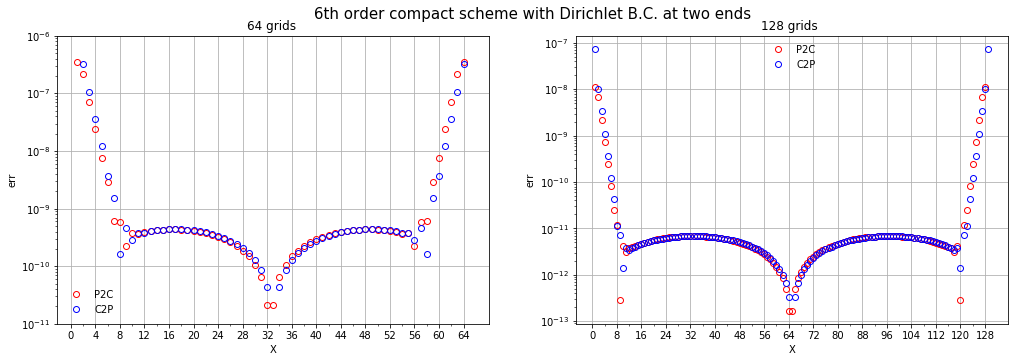

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

%matplotlib inline

cm = plt.cm.get_cmap('RdYlBu')

# Data
cell64P2C=np.loadtxt("cell64P2C")
x1=cell64P2C[:,2]
z1=cell64P2C[:,5]

cell64P2C=np.loadtxt("cell64C2P")
x2=cell64P2C[:,2]
z2=cell64P2C[:,5]

cell128P2C=np.loadtxt("cell128P2C")
x3=cell128P2C[:,2]
z3=cell128P2C[:,5]

cell128P2C=np.loadtxt("cell128C2P")
x4=cell128P2C[:,2]
z4=cell128P2C[:,5]

fig, ax=plt.subplots(2, 1)
fig.suptitle('6th order compact scheme on uniform grids with Dirichlet B.C. at two ends', x=1.1, y=1.1, fontsize = 15)

ax[0]=fig.add_axes([0,0,1,1])
major_ticks = np.arange(0, 65, 4)
minor_ticks = np.arange(0, 65, 2)
ax[0].set_title("64 grids ", fontsize = 12)
ax[0].set_xlabel('X')
ax[0].set_ylabel('err')
ax[0].set_yscale("log")
ax[0].set_xticks(major_ticks)
ax[0].set_xticks(minor_ticks, minor=True)
ax[0].set_ylim([1e-11, 1e-6])

ax[0].plot(x1, z1, ls = 'None', marker = "o", mfc="none", mec="red",  label="P2C")
ax[0].plot(x2, z2, ls = 'None', marker = "o", mfc="none", mec="blue", label="C2P")
ax[0].legend(frameon=False)
plt.grid()

ax[1]=fig.add_axes([1.2, 0, 1, 1])
major_ticks = np.arange(0, 129, 8)
minor_ticks = np.arange(0, 129, 4)
ax[1].set_title("128 grids ", fontsize = 12)
ax[1].set_xlabel('X')
ax[1].set_ylabel('err')
ax[1].set_yscale("log")
ax[1].set_xticks(major_ticks)
ax[1].set_xticks(minor_ticks, minor=True)
#ax[1].set_ylim([1e-11, 1e-6])

ax[1].plot(x3, z3, ls = 'None', marker = "o", mfc="none", mec="red",  label="P2C")
ax[1].plot(x4, z4, ls = 'None', marker = "o", mfc="none", mec="blue", label="C2P")

ax[1].legend(frameon=False)

plt.grid()
plt.show()

### Numerical accuracy at boundaries


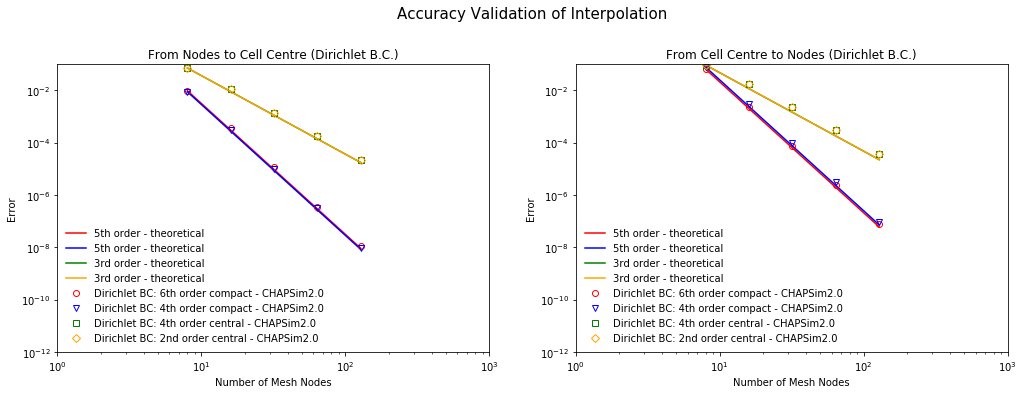

In [25]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red



nsz = np.array([8, 16, 32, 64, 128])


#6cp  [bc1, bulk, bc2]
err6cp_p2c = np.array([\
                       [9.5434761E-03,  1.7211037E-03,  9.5434761E-03],\
                       [3.4698409E-04,  6.6709362E-05,  3.4698409E-04],\
                       [1.1258685E-05,  2.2290771E-06,  1.1258685E-05],\
                       [3.5514444E-07,  7.0848516E-08,  3.5514444E-07],\
                       [1.1124257E-08,  2.2234370E-09 , 1.1124257E-08]])
err6cp_c2p = np.array([\
                       [6.2811484E-02,  2.8606206E-03,  6.2811484E-02],\
                       [2.3200988E-03,  1.0484525E-04,  2.3200988E-03],\
                       [7.5400243E-05,  3.3842761E-06,  7.5400243E-05],\
                       [2.3792178E-06,  1.0659706E-07,  2.3792178E-06],\
                       [7.4530611E-08,  3.3377023E-09,  7.4530611E-08]])
#4cp
err4cp_p2c = np.array([\
                       [8.6800742E-03,  2.5959059E-03,  8.6800742E-03],\
                       [3.0435641E-04,  1.8629060E-04,  3.0435641E-04],\
                       [9.7788676E-06,  1.1593341E-05,  9.7788676E-06],\
                       [3.0769901E-07,  7.2546235E-07,  3.0769901E-07],\
                       [9.6321093E-09,  4.5355088E-08,  9.6321100E-09]])
err4cp_c2p = np.array([\
                       [7.5197094E-02,  5.3377427E-03,  7.5197094E-02],\
                       [2.8859796E-03,  2.1802141E-04,  2.8859796E-03],\
                       [9.4708842E-05,  1.1649460E-05,  9.4708842E-05],\
                       [2.9956593E-06,  7.2633726E-07,  2.9956593E-06],\
                       [9.3897027E-08,  4.5368752E-08,  9.3897036E-08]])
#4cd
err4cd_p2c = np.array([\
                       [7.0326142E-02,  7.8261419E-03,  7.0326142E-02],\
                       [1.0675126E-02,  5.3968797E-04,  1.0675126E-02],\
                       [1.3978001E-03,  3.4557253E-05,  1.3978001E-03],\
                       [1.7674328E-04,  2.1728943E-06,  1.7674328E-04],\
                       [2.2156271E-05,  1.3601063E-07,  2.2156271E-05]])
                       
err4cd_c2p = np.array([\
                       [9.0863155E-02,  8.4709550E-03,  9.0863155E-02],\
                       [1.6867333E-02,  5.5026108E-04,  1.6867333E-02],\
                       [2.2999321E-03,  3.4724460E-05,  2.2999321E-03],\
                       [2.9363624E-04,  2.1755148E-06,  2.9363624E-04],\
                       [3.6897819E-05,  1.3605161E-07,  3.6897819E-05]])
#2cd
err2cd_p2c = np.array([\
                       [7.0326142E-02,  7.0326142E-02,  7.0326142E-02],\
                       [1.0675126E-02,  1.8845514E-02,  1.0675126E-02],\
                       [1.3978001E-03,  4.7920865E-03,  1.3978001E-03],\
                       [1.7674328E-04,  1.2030929E-03,  1.7674328E-04],\
                       [2.2156271E-05,  3.0109059E-04,  2.2156271E-05]])
                       
err2cd_c2p = np.array([\
                       [9.0863155E-02,  7.6120467E-02,  9.0863155E-02],\
                       [1.6867333E-02,  1.9214720E-02,  1.6867333E-02],\
                       [2.2999321E-03,  4.8152733E-03,  2.2999321E-03],\
                       [2.9363624E-04,  1.2045438E-03,  2.9363624E-04],\
                       [3.6897819E-05,  3.0118130E-04,  3.6897819E-05]]) 

# ref - all 
ref6 = (nsz/8)**(-5)
ref4 = (nsz/8)**(-4)
ref2 = (nsz/8)**(-2)

err6cp_p2c_ref =  outer(ref6,  err6cp_p2c[0,:])
err4cp_p2c_ref =  outer(ref4,  err4cp_p2c[0,:])
err4cd_p2c_ref =  outer(ref4,  err4cd_p2c[0,:])
err2cd_p2c_ref =  outer(ref2,  err2cd_p2c[0,:])

err6cp_c2p_ref =  outer(ref6,  err6cp_c2p[0,:])
err4cp_c2p_ref =  outer(ref4,  err4cp_c2p[0,:])
err4cd_c2p_ref =  outer(ref4,  err4cd_c2p[0,:])
err2cd_c2p_ref =  outer(ref2,  err2cd_c2p[0,:])

# fig, axs=plt.subplots(2, 1)
# fig.suptitle('Accuracy Validation of Interpolation', x=1.1, y=1.2, fontsize = 15)


# lblcal = ['6th order compact - CHAPSim2.0', \
#           '4th order compact - CHAPSim2.0', \
#           '4th order central - CHAPSim2.0', \
#           '2nd order central - CHAPSim2.0']
# lblref = ['6th order compact - theoretical', \
#           '4th order compact - theoretical', \
#           '4th order central - theoretical', \
#           '2nd order central - theoretical']

# # P2C - bulk
# axs[0]=fig.add_axes([0,0,1,1])
# axs[0].set_title("From Nodes to Cell Centre (bulk region)", fontsize = 12)
# axs[0].set_xscale("log")
# axs[0].set_yscale("log")
# axs[0].set_xlabel("Number of Mesh Nodes")
# axs[0].set_ylabel("Error")
# axs[0].set_xlim([1,1000])
# axs[0].set_ylim([1e-12,1e-1])

# axs[0].plot(nsz, err6cp_p2c_ref[:,1], label=lblref[0], color="red")
# axs[0].plot(nsz, err4cp_p2c_ref[:,1], label=lblref[1], color="blue")
# axs[0].plot(nsz, err4cd_p2c_ref[:,1], label=lblref[2], color="green")
# axs[0].plot(nsz, err2cd_p2c_ref[:,1], label=lblref[3], color="orange")

# axs[0].plot(nsz, err6cp_p2c[:,1], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
# axs[0].plot(nsz, err4cp_p2c[:,1], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
# axs[0].plot(nsz, err4cd_p2c[:,1], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
# axs[0].plot(nsz, err2cd_p2c[:,1], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
# axs[0].legend(frameon=False)

# # C2P - bulk
# axs[1]=fig.add_axes([1.2, 0, 1, 1])
# axs[1].set_title("From Cell Centre to Nodes (bulk region)", fontsize = 12)
# axs[1].set_xscale("log")
# axs[1].set_yscale("log")
# axs[1].set_xlabel("Number of Mesh Nodes")
# axs[1].set_ylabel("Error")
# axs[1].set_xlim([1,1000])
# axs[1].set_ylim([1e-12,1e-1])

# axs[1].plot(nsz, err6cp_c2p_ref[:,1], label=lblref[0], color="red")
# axs[1].plot(nsz, err4cp_c2p_ref[:,1], label=lblref[1], color="blue")
# axs[1].plot(nsz, err4cd_c2p_ref[:,1], label=lblref[2], color="green")
# axs[1].plot(nsz, err2cd_c2p_ref[:,1], label=lblref[3], color="orange")

# axs[1].plot(nsz, err6cp_c2p[:,1], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
# axs[1].plot(nsz, err4cp_c2p[:,1], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
# axs[1].plot(nsz, err4cd_c2p[:,1], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
# axs[1].plot(nsz, err2cd_c2p[:,1], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
# axs[1].legend(frameon=False)




# ref - bc 
ref6cp = (nsz/8)**(-5)
ref4cp = (nsz/8)**(-5)
ref4cd = (nsz/8)**(-3)
ref2cd = (nsz/8)**(-3)

err6cp_p2c_ref =  outer(ref6cp,  err6cp_p2c[0,:])
err4cp_p2c_ref =  outer(ref4cp,  err4cp_p2c[0,:])
err4cd_p2c_ref =  outer(ref4cd,  err4cd_p2c[0,:])
err2cd_p2c_ref =  outer(ref2cd,  err2cd_p2c[0,:])

err6cp_c2p_ref =  outer(ref6cp,  err6cp_c2p[0,:])
err4cp_c2p_ref =  outer(ref4cp,  err4cp_c2p[0,:])
err4cd_c2p_ref =  outer(ref4cd,  err4cd_c2p[0,:])
err2cd_c2p_ref =  outer(ref2cd,  err2cd_c2p[0,:])

fig, axs=plt.subplots(2, 1)
fig.suptitle('Accuracy Validation of Interpolation on uniform grids at two Dirichilet B.C.', x=1.1, y=1.2, fontsize = 15)

lblcal = ['Dirichlet BC: 6th order compact - CHAPSim2.0', \
          'Dirichlet BC: 4th order compact - CHAPSim2.0', \
          'Dirichlet BC: 4th order central - CHAPSim2.0', \
          'Dirichlet BC: 2nd order central - CHAPSim2.0']

lblref = ['5th order - theoretical', \
          '5th order - theoretical', \
          '3rd order - theoretical', \
          '3rd order - theoretical']

# P2C - bc1
axs[0]=fig.add_axes([0,0,1,1])
axs[0].set_title("From Nodes to Cell Centre (Dirichlet B.C.)", fontsize = 12)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Number of Mesh Nodes")
axs[0].set_ylabel("Error")
axs[0].set_xlim([1,1000])
axs[0].set_ylim([1e-12,1e-1])

axs[0].plot(nsz, err6cp_p2c_ref[:,0], label=lblref[0], color="red")
axs[0].plot(nsz, err4cp_p2c_ref[:,0], label=lblref[1], color="blue")
axs[0].plot(nsz, err4cd_p2c_ref[:,0], label=lblref[2], color="green")
axs[0].plot(nsz, err2cd_p2c_ref[:,0], label=lblref[3], color="orange")

axs[0].plot(nsz, err6cp_p2c[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0].plot(nsz, err4cp_p2c[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0].plot(nsz, err4cd_p2c[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[0].plot(nsz, err2cd_p2c[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[0].legend(frameon=False)

# C2P - bc1
axs[1]=fig.add_axes([1.2, 0, 1, 1])
axs[1].set_title("From Cell Centre to Nodes (Dirichlet B.C.)", fontsize = 12)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Number of Mesh Nodes")
axs[1].set_ylabel("Error")
axs[1].set_xlim([1,1000])
axs[1].set_ylim([1e-12,1e-1])

axs[1].plot(nsz, err6cp_c2p_ref[:,0], label=lblref[0], color="red")
axs[1].plot(nsz, err4cp_c2p_ref[:,0], label=lblref[1], color="blue")
axs[1].plot(nsz, err4cd_c2p_ref[:,0], label=lblref[2], color="green")
axs[1].plot(nsz, err2cd_c2p_ref[:,0], label=lblref[3], color="orange")

axs[1].plot(nsz, err6cp_c2p[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1].plot(nsz, err4cp_c2p[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1].plot(nsz, err4cd_c2p[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[1].plot(nsz, err2cd_c2p[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[1].legend(frameon=False)

plt.show()

## Interpolation on stretching mesh with Dirichilet B.C.

### Mesh Stretching

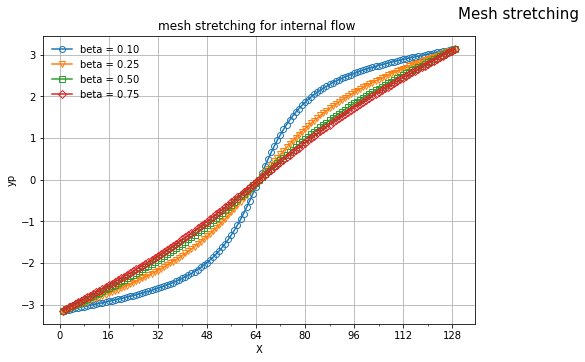

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

%matplotlib inline

cm = plt.cm.get_cmap('RdYlBu')

# Data
rp10=np.loadtxt("stretching128_rp10.dat")
x0=rp10[:,0]
y0=rp10[:,1]

rp25=np.loadtxt("stretching128_rp25.dat")
x1=rp25[:,0]
y1=rp25[:,1]

rp50=np.loadtxt("stretching128_rp50.dat")
x2=rp50[:,0]
y2=rp50[:,1]

rp75=np.loadtxt("stretching128_rp75.dat")
x3=rp75[:,0]
y3=rp75[:,1]

fig, ax=plt.subplots(2, 1)
fig.suptitle('Mesh stretching', x=1.1, y=1.1, fontsize = 15)

ax[0]=fig.add_axes([0,0,1,1])
major_ticks = np.arange(0, 130, 16)
minor_ticks = np.arange(0, 130, 8)
ax[0].set_title("mesh stretching for internal flow ", fontsize = 12)
ax[0].set_xlabel('X')
ax[0].set_ylabel('yp')
ax[0].set_xticks(major_ticks)
ax[0].set_xticks(minor_ticks, minor=True)

ax[0].plot(x0, y0, marker = "o", mfc="none", label="beta = 0.10")
ax[0].plot(x1, y1, marker = "v", mfc="none", label="beta = 0.25")
ax[0].plot(x2, y2, marker = "s", mfc="none", label="beta = 0.50")
ax[0].plot(x3, y3, marker = "D", mfc="none", label="beta = 0.75")
ax[0].legend(frameon=False)

plt.grid()
plt.show()

###  Interpolation on stretching mesh with periodic B.C.

$\beta = 0.1$

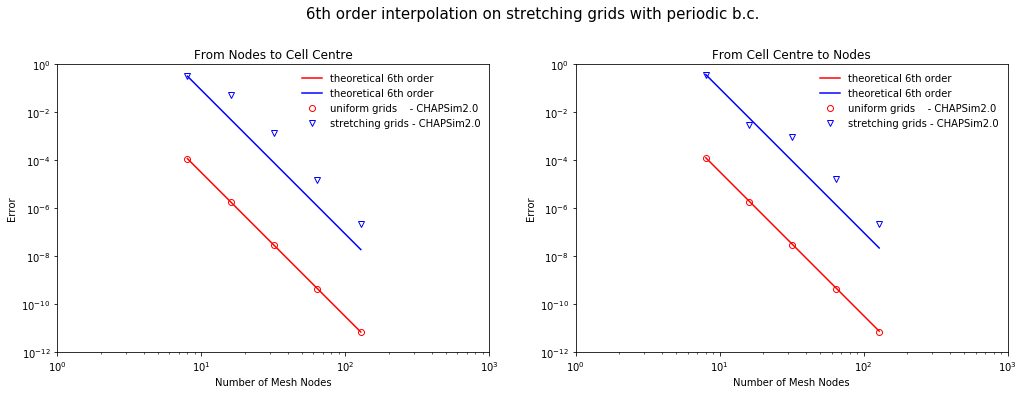

In [30]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red

nsz = np.array([8, 16, 32, 64, 128])

err6cp_p2c_uniform = np.array([1.1444298E-04, 1.7905790E-06, 2.7979968E-08, 4.3719028E-10, 6.8323125E-12])
err6cp_c2p_uniform = np.array([1.2387219E-04, 1.8256585E-06, 2.8115351E-08, 4.3771764E-10, 6.8349770E-12])

err6cp_c2p_stretch = np.array([3.6179270E-01, 2.7933010E-03, 9.0174085E-04, 1.5808511E-05, 2.0960803E-07]) # u in y
err6cp_p2c_stretch = np.array([3.1150407E-01, 4.8967413E-02, 1.3968441E-03, 1.4398166E-05, 2.1451914E-07]) # v in y


err6cp_dudy_c2p_stretch = np.array([2.1677533E-01, 3.0056357E-02, 1.2054692E-03, 1.9874432E-05, 2.9208665E-07])
err6cp_dudy_c2c_stretch = np.array([2.6192374E-01, 2.1496527E-02, 3.0720737E-03, 4.8894992E-05, 7.9271718E-07])
err6cp_dvdy_p2c_stretch = np.array([1.7293589E-01, 8.8881533E-03, 6.9076201E-04, 1.5251021E-05, 2.7457269E-07])
err6cp_dvdy_p2p_stretch = np.array([5.1421820E-01, 1.1587382E-01, 5.4204498E-03, 6.5672835E-05, 8.4432955E-07])


# ref - bc 
ref6cp = (nsz/8)**(-6)

err6cp_p2c_ref_uniform = outer(ref6cp, err6cp_p2c_uniform[0])
err6cp_c2p_ref_uniform = outer(ref6cp, err6cp_c2p_uniform[0])
err6cp_p2c_ref_stretch = outer(ref6cp, err6cp_p2c_stretch[0])
err6cp_c2p_ref_stretch = outer(ref6cp, err6cp_c2p_stretch[0])

lblref = ['theoretical 6th order', \
          'theoretical 6th order']

lblcal = ['uniform grids    - CHAPSim2.0', \
          'stretching grids - CHAPSim2.0']


fig, axs=plt.subplots(2, 1)
fig.suptitle('6th order interpolation on stretching grids with periodic b.c.', x=1.1, y=1.2, fontsize = 15)

# P2C
axs[0]=fig.add_axes([0,0,1,1])
axs[0].set_title("From Nodes to Cell Centre", fontsize = 12)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel("Number of Mesh Nodes")
axs[0].set_ylabel("Error")
axs[0].set_xlim([1,1000])
axs[0].set_ylim([1e-12,1.])

axs[0].plot(nsz, err6cp_p2c_ref_uniform, label=lblref[0], color="red")
axs[0].plot(nsz, err6cp_p2c_ref_stretch, label=lblref[1], color="blue")
axs[0].plot(nsz, err6cp_p2c_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0].plot(nsz, err6cp_p2c_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0].legend(frameon=False)

# C2P
axs[1]=fig.add_axes([1.2, 0, 1, 1])
axs[1].set_title("From Cell Centre to Nodes", fontsize = 12)
axs[1].set_xscale("log")
axs[1].set_yscale("log")
axs[1].set_xlabel("Number of Mesh Nodes")
axs[1].set_ylabel("Error")
axs[1].set_xlim([1,1000])
axs[1].set_ylim([1e-12,1.])

axs[1].plot(nsz, err6cp_c2p_ref_uniform, label=lblref[0], color="red")
axs[1].plot(nsz, err6cp_c2p_ref_stretch, label=lblref[1], color="blue")
axs[1].plot(nsz, err6cp_c2p_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1].plot(nsz, err6cp_c2p_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1].legend(frameon=False)

plt.show()

# First Deriviative
The input velocity stored at staggered $(i', j, k)$ is
$u(x,y,z)=sin(x) + sin(y) + sin(z)$
The first deriviative involves,
* du/dx, from face $(i', j, k)$ to cell centre $(i, j, k)$, called P2C
* du/dx, from face $(i', j, k)$ to face $(i', j, k)$, called P2P
* du/dy, from face $(i', j, k)$ to edge $(i', j', k)$, called C2P
* du/dy, from face $(i', j, k)$ to face $(i', j, k)$, called P2P
## First Deriviative on uniform mesh with Periodic B.C.

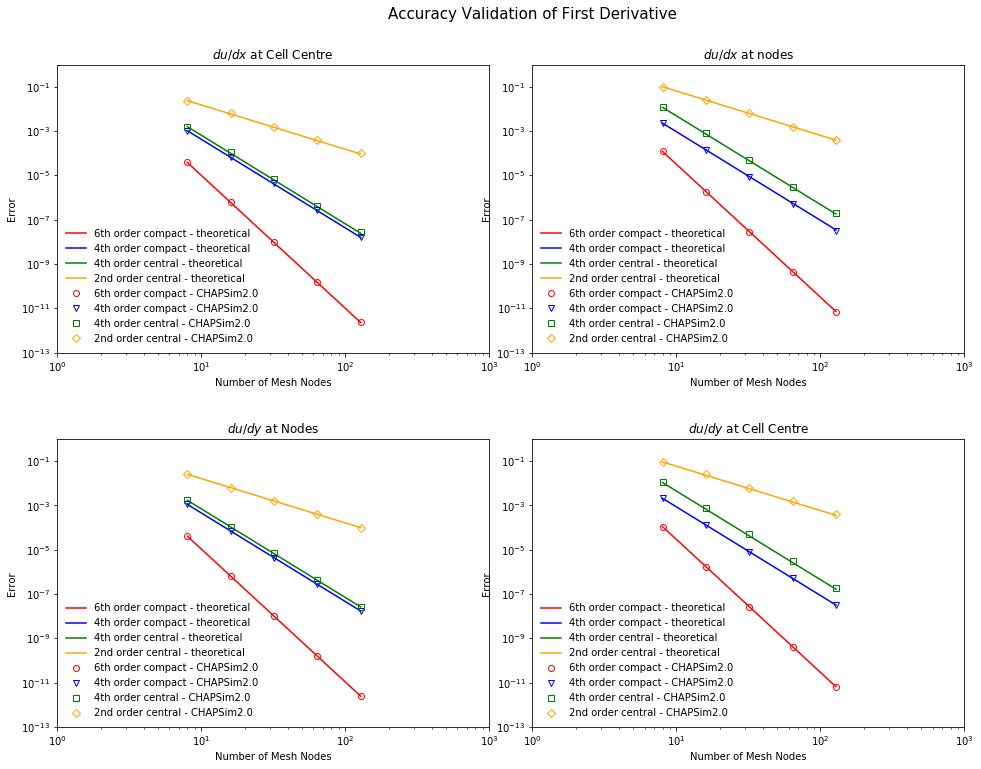

In [117]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red


nsz = np.array([8, 16, 32, 64, 128])

# calcuated from CHAPSIM2.0
err6cp_dudx_p2c = np.array([3.8181667E-05, 6.1756630E-07, 9.7274324E-09, 1.5229418E-10, 2.3895330E-12])
err6cp_dudx_p2p = np.array([1.2025461E-04, 1.7782270E-06, 2.7410411E-08, 4.2684534E-10, 6.6758821E-12])
err6cp_dudy_c2p = np.array([4.1327539E-05, 6.2966514E-07, 9.7744993E-09, 1.5248158E-10, 2.3929747E-12])
err6cp_dudy_c2c = np.array([1.1110077E-04, 1.7440589E-06, 2.7278424E-08, 4.2633397E-10, 6.6667782E-12])

err4cp_dudx_p2c = np.array([1.0387320E-03, 6.8872713E-05, 4.3662301E-06, 2.7385276E-07, 1.7130857E-08])
err4cp_dudx_p2p = np.array([2.2746915E-03, 1.3456686E-04, 8.2954552E-06, 5.1668444E-07, 3.2265010E-08])
err4cp_dudy_c2p = np.array([1.1243154E-03, 7.0222009E-05, 4.3873565E-06, 2.7418303E-07, 1.7136020E-08])
err4cp_dudy_c2c = np.array([2.1015409E-03, 1.3198120E-04, 8.2555103E-06, 5.1606207E-07, 3.2255286E-08])

err4cd_dudx_p2c = np.array([1.5885044E-03, 1.0833514E-04, 6.9177997E-06, 4.3467861E-07, 2.7203695E-08])
err4cd_dudx_p2p = np.array([1.1784836E-02, 7.7829418E-04, 4.9317943E-05, 3.0930006E-06, 1.9347897E-07])
err4cd_dudy_c2p = np.array([1.7193847E-03, 1.1045756E-04, 6.9512720E-06, 4.3520283E-07, 2.7211893E-08])
err4cd_dudy_c2c = np.array([1.0887769E-02, 7.6333948E-04, 4.9080463E-05, 3.0892749E-06, 1.9342070E-07])

err2cd_dudx_p2c = np.array([2.3563216E-02, 6.2899220E-03, 1.5978755E-03, 4.0106317E-04, 1.0036555E-04])
err2cd_dudx_p2p = np.array([9.9683684E-02, 2.5504642E-02, 6.4131489E-03, 1.6056070E-03, 4.0154685E-04])
err2cd_dudy_c2p = np.array([2.5504642E-02, 6.4131489E-03, 1.6056070E-03, 4.0154685E-04, 1.0039578E-04])
err2cd_dudy_c2c = np.array([9.2095715E-02, 2.5014577E-02, 6.3822678E-03, 1.6036729E-03, 4.0142591E-04])

# theoretical errors based on the first nsz = 8
err6cp_dudx_p2c_ref = err6cp_dudx_p2c[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_dudx_p2c_ref = err4cp_dudx_p2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_dudx_p2c_ref = err4cd_dudx_p2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_dudx_p2c_ref = err2cd_dudx_p2c[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

err6cp_dudx_p2p_ref = err6cp_dudx_p2p[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_dudx_p2p_ref = err4cp_dudx_p2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_dudx_p2p_ref = err4cd_dudx_p2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_dudx_p2p_ref = err2cd_dudx_p2p[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

err6cp_dudy_c2p_ref = err6cp_dudy_c2p[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_dudy_c2p_ref = err4cp_dudy_c2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_dudy_c2p_ref = err4cd_dudy_c2p[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_dudy_c2p_ref = err2cd_dudy_c2p[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

err6cp_dudy_c2c_ref = err6cp_dudy_c2c[0] * np.array([1, 2**(-6), 4**(-6), 8**(-6), 16**(-6)])
err4cp_dudy_c2c_ref = err4cp_dudy_c2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err4cd_dudy_c2c_ref = err4cd_dudy_c2c[0] * np.array([1, 2**(-4), 4**(-4), 8**(-4), 16**(-4)])
err2cd_dudy_c2c_ref = err2cd_dudy_c2c[0] * np.array([1, 2**(-2), 4**(-2), 8**(-2), 16**(-2)])

lblref = ['6th order compact - theoretical', \
          '4th order compact - theoretical', \
          '4th order central - theoretical', \
          '2nd order central - theoretical']

lblcal = ['6th order compact - CHAPSim2.0', \
          '4th order compact - CHAPSim2.0', \
          '4th order central - CHAPSim2.0', \
          '2nd order central - CHAPSim2.0']

fig, axs=plt.subplots(2, 2)
fig.suptitle('Accuracy Validation of First Derivative', x=1.1, y=1.2, fontsize = 15)
# du/dx, p2c
axs[0, 0]=fig.add_axes([0,0,1,1])
axs[0, 0].set_title("$du/dx$ at Cell Centre", fontsize = 12)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("Number of Mesh Nodes")
axs[0, 0].set_ylabel("Error")
axs[0, 0].set_xlim([1,1000])
axs[0, 0].set_ylim([1e-13,1])

axs[0, 0].plot(nsz, err6cp_dudx_p2c_ref, label=lblref[0], color="red")
axs[0, 0].plot(nsz, err4cp_dudx_p2c_ref, label=lblref[1], color="blue")
axs[0, 0].plot(nsz, err4cd_dudx_p2c_ref, label=lblref[2], color="green")
axs[0, 0].plot(nsz, err2cd_dudx_p2c_ref, label=lblref[3], color="orange")

axs[0, 0].plot(nsz, err6cp_dudx_p2c, label=lblcal[0], ls = "none", marker = "o", mfc="none", mec="red")
axs[0, 0].plot(nsz, err4cp_dudx_p2c, label=lblcal[1], ls = "none", marker = "v", mfc="none", mec="blue")
axs[0, 0].plot(nsz, err4cd_dudx_p2c, label=lblcal[2], ls = "none", marker = "s", mfc="none", mec="green")
axs[0, 0].plot(nsz, err2cd_dudx_p2c, label=lblcal[3], ls = "none", marker = "D", mfc="none", mec="orange")
axs[0, 0].legend(frameon=False)

# du/dx, p2p
axs[0, 1]=fig.add_axes([1.1,0,1,1])
axs[0, 1].set_title("$du/dx$ at nodes", fontsize = 12)
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("Number of Mesh Nodes")
axs[0, 1].set_ylabel("Error")
axs[0, 1].set_xlim([1,1000])
axs[0, 1].set_ylim([1e-13,1])

axs[0, 1].plot(nsz, err6cp_dudx_p2p_ref, label=lblref[0], color="red")
axs[0, 1].plot(nsz, err4cp_dudx_p2p_ref, label=lblref[1], color="blue")
axs[0, 1].plot(nsz, err4cd_dudx_p2p_ref, label=lblref[2], color="green")
axs[0, 1].plot(nsz, err2cd_dudx_p2p_ref, label=lblref[3], color="orange")

axs[0, 1].plot(nsz, err6cp_dudx_p2p, label=lblcal[0], ls = "none", marker = "o", mfc="none", mec="red")
axs[0, 1].plot(nsz, err4cp_dudx_p2p, label=lblcal[1], ls = "none", marker = "v", mfc="none", mec="blue")
axs[0, 1].plot(nsz, err4cd_dudx_p2p, label=lblcal[2], ls = "none", marker = "s", mfc="none", mec="green")
axs[0, 1].plot(nsz, err2cd_dudx_p2p, label=lblcal[3], ls = "none", marker = "D", mfc="none", mec="orange")
axs[0, 1].legend(frameon=False)

# du/dy, c2p
axs[1, 0]=fig.add_axes([0,-1.3,1,1])
axs[1, 0].set_title("$du/dy$ at Nodes", fontsize = 12)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("Number of Mesh Nodes")
axs[1, 0].set_ylabel("Error")
axs[1, 0].set_xlim([1,1000])
axs[1, 0].set_ylim([1e-13,1])

axs[1, 0].plot(nsz, err6cp_dudy_c2p_ref, label=lblref[0], color="red")
axs[1, 0].plot(nsz, err4cp_dudy_c2p_ref, label=lblref[1], color="blue")
axs[1, 0].plot(nsz, err4cd_dudy_c2p_ref, label=lblref[2], color="green")
axs[1, 0].plot(nsz, err2cd_dudy_c2p_ref, label=lblref[3], color="orange")

axs[1, 0].plot(nsz, err6cp_dudy_c2p, label=lblcal[0], ls = "none", marker = "o", mfc="none", mec="red")
axs[1, 0].plot(nsz, err4cp_dudy_c2p, label=lblcal[1], ls = "none", marker = "v", mfc="none", mec="blue")
axs[1, 0].plot(nsz, err4cd_dudy_c2p, label=lblcal[2], ls = "none", marker = "s", mfc="none", mec="green")
axs[1, 0].plot(nsz, err2cd_dudy_c2p, label=lblcal[3], ls = "none", marker = "D", mfc="none", mec="orange")
axs[1, 0].legend(frameon=False)

# du/dy, c2c
axs[1, 1]=fig.add_axes([1.1,-1.3,1,1])
axs[1, 1].set_title("$du/dy$ at Cell Centre", fontsize = 12)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Number of Mesh Nodes")
axs[1, 1].set_ylabel("Error")
axs[1, 1].set_xlim([1,1000])
axs[1, 1].set_ylim([1e-13,1])

axs[1, 1].plot(nsz, err6cp_dudy_c2c_ref, label=lblref[0], color="red")
axs[1, 1].plot(nsz, err4cp_dudy_c2c_ref, label=lblref[1], color="blue")
axs[1, 1].plot(nsz, err4cd_dudy_c2c_ref, label=lblref[2], color="green")
axs[1, 1].plot(nsz, err2cd_dudy_c2c_ref, label=lblref[3], color="orange")

axs[1, 1].plot(nsz, err6cp_dudy_c2c, label=lblcal[0], ls = "none", marker = "o", mfc="none", mec="red")
axs[1, 1].plot(nsz, err4cp_dudy_c2c, label=lblcal[1], ls = "none", marker = "v", mfc="none", mec="blue")
axs[1, 1].plot(nsz, err4cd_dudy_c2c, label=lblcal[2], ls = "none", marker = "s", mfc="none", mec="green")
axs[1, 1].plot(nsz, err2cd_dudy_c2c, label=lblcal[3], ls = "none", marker = "D", mfc="none", mec="orange")
axs[1, 1].legend(frameon=False)


plt.show()

## First Deriviative on uniform mesh with Dirichlet B.C.

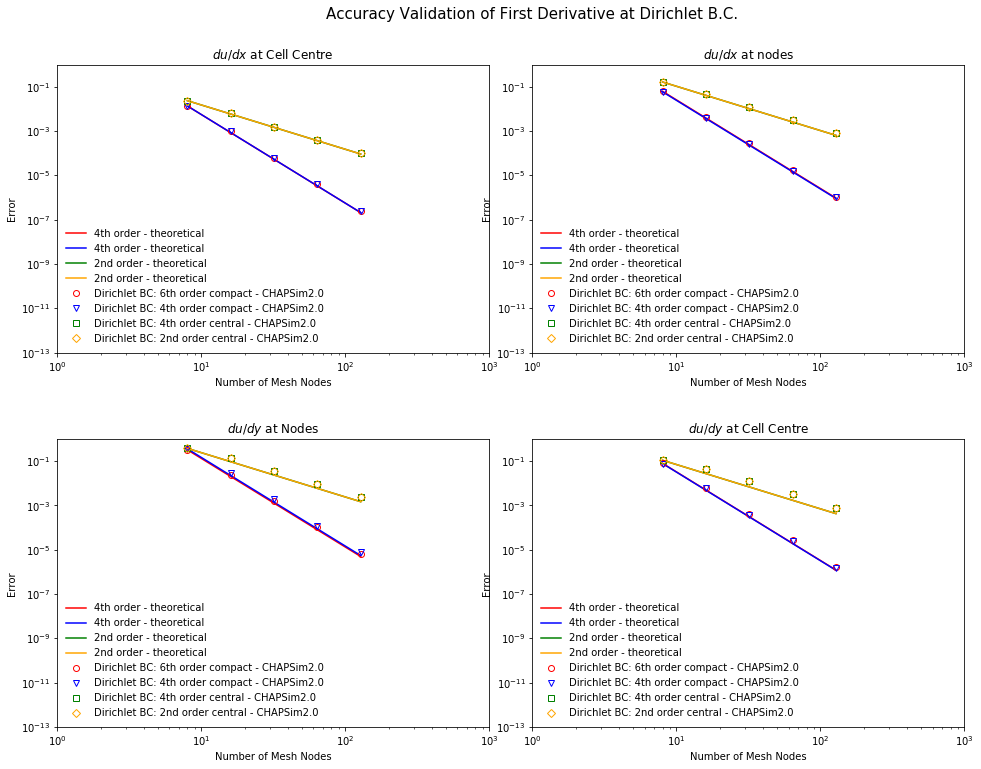

In [30]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red


nsz = np.array([8, 16, 32, 64, 128])

# calcuated from CHAPSIM2.0

# 6th order compact
err6cp_dudx_p2c = np.array([\
                       [1.3640428E-02,  4.1525898E-05,  1.3640428E-02],\
                       [9.7659314E-04,  2.3926883E-06,  9.7659314E-04],\
                       [6.3120248E-05,  2.4439137E-07,  6.3120248E-05],\
                       [3.9781573E-06,  1.6994502E-08,  3.9781573E-06],\
                       [2.4915502E-07,  1.0900389E-09,  2.4915502E-07]])
err6cp_dudx_p2p = np.array([\
                       [6.2408274E-02,  7.6220990E-03,  6.2408274E-02],\
                       [4.3576762E-03,  5.3472603E-04,  4.3576762E-03],\
                       [2.8016231E-04,  3.4658844E-05,  2.8016231E-04],\
                       [1.7634208E-05,  2.1862388E-06,  1.7634208E-05],\
                       [1.1040847E-06,  1.3695622E-07,  1.1040847E-06]])
err6cp_dudy_c2p = np.array([\
                       [3.2462210E-01,  2.3270633E-03,  3.2462210E-01],\
                       [2.4917004E-02,  1.7913664E-04,  2.4917004E-02],\
                       [1.6357142E-03,  1.1794771E-05,  1.6357142E-03],\
                       [1.0348189E-04,  7.4683395E-07,  1.0348189E-04],\
                       [6.4872451E-06,  4.6829307E-08,  6.4872455E-06]])
err6cp_dudy_c2c = np.array([\
                       [8.0094557E-02,  8.5129694E-03,  8.0094557E-02],\
                       [6.2804499E-03,  7.3038652E-04,  6.2804499E-03],\
                       [4.1395801E-04,  4.8661085E-05,  4.1395801E-04],\
                       [2.6215674E-05,  3.0902512E-06,  2.6215674E-05],\
                       [1.6438774E-06,  1.9391292E-07,  1.6438774E-06]])  
# 4th order compact                            
err4cp_dudx_p2c = np.array([\
                       [1.3658456E-02,  1.0398702E-03,  1.3658456E-02],\
                       [9.7471117E-04,  6.8872714E-05,  9.7471117E-04],\
                       [6.2936108E-05,  4.3662301E-06,  6.2936108E-05],\
                       [3.9655217E-06,  2.7385276E-07,  3.9655217E-06],\
                       [2.4834733E-07,  1.7486851E-08,  2.4834733E-07]])
err4cp_dudx_p2p = np.array([\
                       [5.9224243E-02,  4.4380674E-03,  5.9224243E-02],\
                       [4.0265520E-03,  2.0360179E-04,  4.0265520E-03],\
                       [2.5687807E-04,  1.1998797E-05,  2.5687807E-04],\
                       [1.6136885E-05,  8.1481566E-07,  1.6136885E-05],\
                       [1.0098385E-06,  5.1963658E-08,  1.0098385E-06]])
err4cp_dudy_c2p = np.array([\
                       [3.6087078E-01,  1.1274317E-03,  3.6087078E-01],\
                       [2.8801497E-02,  7.0222010E-05,  2.8801497E-02],\
                       [1.9089224E-03,  4.3873565E-06,  1.9089224E-03],\
                       [1.2105454E-04,  2.7418303E-07,  1.2105454E-04],\
                       [7.5933901E-06,  1.7669744E-08,  7.5933905E-06]])
err4cp_dudy_c2c = np.array([\
                       [7.8100075E-02,  6.5184879E-03,  7.8100075E-02],\
                       [5.9090267E-03,  3.5896329E-04,  5.9090267E-03],\
                       [3.8630948E-04,  2.1012554E-05,  3.8630948E-04],\
                       [2.4414130E-05,  1.2887072E-06,  2.4414130E-05],\
                       [1.5301153E-06,  8.0150816E-08,  1.5301153E-06]]) 
# 4th order central difference
err4cd_dudx_p2c = np.array([\
                       [2.3563216E-02,  1.5885044E-03,  2.3563216E-02],\
                       [6.2899220E-03,  1.0833514E-04,  6.2899220E-03],\
                       [1.5978755E-03,  6.9177997E-06,  1.5978755E-03],\
                       [4.0106317E-04,  4.3467861E-07,  4.0106317E-04],\
                       [1.0036555E-04,  2.7203695E-08,  1.0036555E-04]])
err4cd_dudx_p2p = np.array([\
                       [1.6401286E-01,  1.1784836E-02,  1.6401286E-01],\
                       [4.8674401E-02,  7.7829418E-04,  4.8674401E-02],\
                       [1.2678344E-02,  4.9317943E-05,  1.2678344E-02],\
                       [3.2019349E-03,  3.0930006E-06,  3.2019349E-03],\
                       [8.0251326E-04,  1.9347897E-07,  8.0251326E-04]])
err4cd_dudy_c2p = np.array([\
                       [3.7814455E-01,  1.7193847E-03,  3.7814455E-01],\
                       [1.3333711E-01,  1.1045756E-04,  1.3333711E-01],\
                       [3.6024904E-02,  6.9512720E-06,  3.6024904E-02],\
                       [9.1787776E-03,  4.3520283E-07,  9.1787776E-03],\
                       [2.3055484E-03,  2.7211893E-08,  2.3055484E-03]])
err4cd_dudy_c2c = np.array([\
                       [1.0972888E-01,  1.0887769E-02,  1.0972888E-01],\
                       [4.4860553E-02,  7.6333948E-04,  4.4860553E-02],\
                       [1.2432988E-02,  4.9080463E-05,  1.2432988E-02],\
                       [3.1864893E-03,  3.0892749E-06,  3.1864893E-03],\
                       [8.0154617E-04,  1.9342070E-07,  8.0154617E-04]]) 
# 2nd order central difference
err2cd_dudx_p2c = np.array([\
                       [2.3563216E-02,  2.3563216E-02,  2.3563216E-02],\
                       [6.2899220E-03,  6.2899220E-03,  6.2899220E-03],\
                       [1.5978755E-03,  1.5978755E-03,  1.5978755E-03],\
                       [4.0106317E-04,  4.0106317E-04,  4.0106317E-04],\
                       [1.0036555E-04,  1.0036555E-04,  1.0036555E-04]])
err2cd_dudx_p2p = np.array([\
                       [1.6401286E-01,  9.9683684E-02,  1.6401286E-01],\
                       [4.8674401E-02,  2.5504642E-02,  4.8674401E-02],\
                       [1.2678344E-02,  6.4131489E-03,  1.2678344E-02],\
                       [3.2019349E-03,  1.6056070E-03,  3.2019349E-03],\
                       [8.0251326E-04,  4.0154685E-04,  8.0251326E-04]])
err2cd_dudy_c2p = np.array([\
                       [3.7814455E-01,  2.5504642E-02,  3.7814455E-01],\
                       [1.3333711E-01,  6.4131489E-03,  1.3333711E-01],\
                       [3.6024904E-02,  1.6056070E-03,  3.6024904E-02],\
                       [9.1787776E-03,  4.0154685E-04,  9.1787776E-03],\
                       [2.3055484E-03,  1.0039578E-04,  2.3055484E-03]])
err2cd_dudy_c2c = np.array([\
                       [1.0972888E-01,  9.2095715E-02,  1.0972888E-01],\
                       [4.4860553E-02,  2.5014577E-02,  4.4860553E-02],\
                       [1.2432988E-02,  6.3822678E-03,  1.2432988E-02],\
                       [3.1864893E-03,  1.6036729E-03,  3.1864893E-03],\
                       [8.0154617E-04,  4.0142591E-04,  8.0154617E-04]])
# ref - bc 
ref6cp = (nsz/8)**(-4)
ref4cp = (nsz/8)**(-4)
ref4cd = (nsz/8)**(-2)
ref2cd = (nsz/8)**(-2)

err6cp_dudx_p2c_ref =  outer(ref6cp,  err6cp_dudx_p2c[0,:])
err4cp_dudx_p2c_ref =  outer(ref4cp,  err4cp_dudx_p2c[0,:])
err4cd_dudx_p2c_ref =  outer(ref4cd,  err4cd_dudx_p2c[0,:])
err2cd_dudx_p2c_ref =  outer(ref2cd,  err2cd_dudx_p2c[0,:])

err6cp_dudx_p2p_ref =  outer(ref6cp,  err6cp_dudx_p2p[0,:])
err4cp_dudx_p2p_ref =  outer(ref4cp,  err4cp_dudx_p2p[0,:])
err4cd_dudx_p2p_ref =  outer(ref4cd,  err4cd_dudx_p2p[0,:])
err2cd_dudx_p2p_ref =  outer(ref2cd,  err2cd_dudx_p2p[0,:])
                            
err6cp_dudy_c2p_ref =  outer(ref6cp,  err6cp_dudy_c2p[0,:])
err4cp_dudy_c2p_ref =  outer(ref4cp,  err4cp_dudy_c2p[0,:])
err4cd_dudy_c2p_ref =  outer(ref4cd,  err4cd_dudy_c2p[0,:])
err2cd_dudy_c2p_ref =  outer(ref2cd,  err2cd_dudy_c2p[0,:])
                            
err6cp_dudy_c2c_ref =  outer(ref6cp,  err6cp_dudy_c2c[0,:])
err4cp_dudy_c2c_ref =  outer(ref4cp,  err4cp_dudy_c2c[0,:])
err4cd_dudy_c2c_ref =  outer(ref4cd,  err4cd_dudy_c2c[0,:])
err2cd_dudy_c2c_ref =  outer(ref2cd,  err2cd_dudy_c2c[0,:])
                            
                            

lblcal = ['Dirichlet BC: 6th order compact - CHAPSim2.0', \
          'Dirichlet BC: 4th order compact - CHAPSim2.0', \
          'Dirichlet BC: 4th order central - CHAPSim2.0', \
          'Dirichlet BC: 2nd order central - CHAPSim2.0']

lblref = ['4th order - theoretical', \
          '4th order - theoretical', \
          '2nd order - theoretical', \
          '2nd order - theoretical']

fig, axs=plt.subplots(2, 2)
fig.suptitle('Accuracy Validation of First Derivative at Dirichlet B.C.', x=1.1, y=1.2, fontsize = 15)
# B.C.                            
# du/dx, p2c
axs[0, 0]=fig.add_axes([0,0,1,1])
axs[0, 0].set_title("$du/dx$ at Cell Centre", fontsize = 12)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("Number of Mesh Nodes")
axs[0, 0].set_ylabel("Error")
axs[0, 0].set_xlim([1,1000])
axs[0, 0].set_ylim([1e-13,1])

axs[0, 0].plot(nsz, err6cp_dudx_p2c_ref[:,0], label=lblref[0], color="red")
axs[0, 0].plot(nsz, err4cp_dudx_p2c_ref[:,0], label=lblref[1], color="blue")
axs[0, 0].plot(nsz, err4cd_dudx_p2c_ref[:,0], label=lblref[2], color="green")
axs[0, 0].plot(nsz, err2cd_dudx_p2c_ref[:,0], label=lblref[3], color="orange")

axs[0, 0].plot(nsz, err6cp_dudx_p2c[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0, 0].plot(nsz, err4cp_dudx_p2c[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0, 0].plot(nsz, err4cd_dudx_p2c[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[0, 0].plot(nsz, err2cd_dudx_p2c[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[0, 0].legend(frameon=False)

# du/dx, p2p
axs[0, 1]=fig.add_axes([1.1,0,1,1])
axs[0, 1].set_title("$du/dx$ at nodes", fontsize = 12)
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("Number of Mesh Nodes")
axs[0, 1].set_ylabel("Error")
axs[0, 1].set_xlim([1,1000])
axs[0, 1].set_ylim([1e-13,1])

axs[0, 1].plot(nsz, err6cp_dudx_p2p_ref[:,0], label=lblref[0], color="red")
axs[0, 1].plot(nsz, err4cp_dudx_p2p_ref[:,0], label=lblref[1], color="blue")
axs[0, 1].plot(nsz, err4cd_dudx_p2p_ref[:,0], label=lblref[2], color="green")
axs[0, 1].plot(nsz, err2cd_dudx_p2p_ref[:,0], label=lblref[3], color="orange")

axs[0, 1].plot(nsz, err6cp_dudx_p2p[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0, 1].plot(nsz, err4cp_dudx_p2p[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0, 1].plot(nsz, err4cd_dudx_p2p[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[0, 1].plot(nsz, err2cd_dudx_p2p[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[0, 1].legend(frameon=False)

                        
# du/dy, p2c
axs[1, 0]=fig.add_axes([0,-1.3,1,1])
axs[1, 0].set_title("$du/dy$ at Nodes", fontsize = 12)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("Number of Mesh Nodes")
axs[1, 0].set_ylabel("Error")
axs[1, 0].set_xlim([1,1000])
axs[1, 0].set_ylim([1e-13,1])

axs[1, 0].plot(nsz, err6cp_dudy_c2p_ref[:,0], label=lblref[0], color="red")
axs[1, 0].plot(nsz, err4cp_dudy_c2p_ref[:,0], label=lblref[1], color="blue")
axs[1, 0].plot(nsz, err4cd_dudy_c2p_ref[:,0], label=lblref[2], color="green")
axs[1, 0].plot(nsz, err2cd_dudy_c2p_ref[:,0], label=lblref[3], color="orange")

axs[1, 0].plot(nsz, err6cp_dudy_c2p[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1, 0].plot(nsz, err4cp_dudy_c2p[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1, 0].plot(nsz, err4cd_dudy_c2p[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[1, 0].plot(nsz, err2cd_dudy_c2p[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[1, 0].legend(frameon=False)

# du/dy, p2p
axs[1, 1]=fig.add_axes([1.1,-1.3,1,1])
axs[1, 1].set_title("$du/dy$ at Cell Centre", fontsize = 12)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Number of Mesh Nodes")
axs[1, 1].set_ylabel("Error")
axs[1, 1].set_xlim([1,1000])
axs[1, 1].set_ylim([1e-13,1])

axs[1, 1].plot(nsz, err6cp_dudy_c2c_ref[:,0], label=lblref[0], color="red")
axs[1, 1].plot(nsz, err4cp_dudy_c2c_ref[:,0], label=lblref[1], color="blue")
axs[1, 1].plot(nsz, err4cd_dudy_c2c_ref[:,0], label=lblref[2], color="green")
axs[1, 1].plot(nsz, err2cd_dudy_c2c_ref[:,0], label=lblref[3], color="orange")

axs[1, 1].plot(nsz, err6cp_dudy_c2c[:,0], label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1, 1].plot(nsz, err4cp_dudy_c2c[:,0], label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1, 1].plot(nsz, err4cd_dudy_c2c[:,0], label=lblcal[2], ls = 'None', marker = "s", mfc="none", mec="green")
axs[1, 1].plot(nsz, err2cd_dudy_c2c[:,0], label=lblcal[3], ls = 'None', marker = "D", mfc="none", mec="orange")
axs[1, 1].legend(frameon=False)                            
                            
plt.show()

## First Deriviative on stretching mesh with periodic B.C.

$\beta = 0.1$

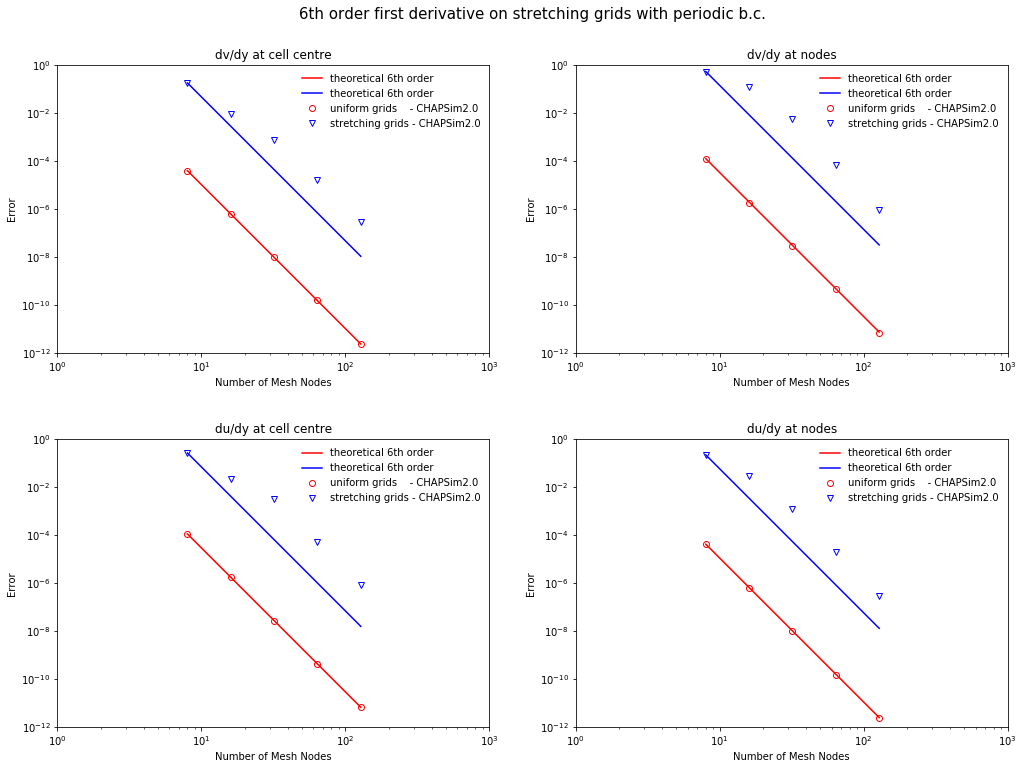

In [33]:
from matplotlib import pyplot as plt
import numpy as np
import pylab as pl
import mpl_toolkits.axisartist as AA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.axes_grid1 import host_subplot
import math
import itertools

%matplotlib inline

plt.rc('figure', facecolor="white")
plt.rc('legend', fontsize=10)
rcParams['legend.loc'] = 'best'
cbrg = cm.get_cmap(name='brg', lut=None) ## 1=green 0=blue  0.5=red

nsz = np.array([8, 16, 32, 64, 128])

err6cp_dudy_c2p_uniform = np.array([4.1327539E-05, 6.2966514E-07, 9.7744993E-09, 1.5248158E-10, 2.3929747E-12])
err6cp_dudy_c2c_uniform = np.array([1.1110077E-04, 1.7440589E-06, 2.7278424E-08, 4.2633397E-10, 6.6667782E-12])
err6cp_dvdy_p2c_uniform = np.array([3.8181667E-05, 6.1756630E-07, 9.7274324E-09, 1.5229418E-10, 2.3895330E-12])
err6cp_dvdy_p2p_uniform = np.array([1.2025461E-04, 1.7782270E-06, 2.7410411E-08, 4.2684534E-10, 6.6758821E-12])



err6cp_dudy_c2p_stretch = np.array([2.1677533E-01, 3.0056357E-02, 1.2054692E-03, 1.9874432E-05, 2.9208665E-07])
err6cp_dudy_c2c_stretch = np.array([2.6192374E-01, 2.1496527E-02, 3.0720737E-03, 4.8894992E-05, 7.9271718E-07])
err6cp_dvdy_p2c_stretch = np.array([1.7293589E-01, 8.8881533E-03, 6.9076201E-04, 1.5251021E-05, 2.7457269E-07])
err6cp_dvdy_p2p_stretch = np.array([5.1421820E-01, 1.1587382E-01, 5.4204498E-03, 6.5672835E-05, 8.4432955E-07])


# ref - bc 
ref6cp = (nsz/8)**(-6)

err6cp_p2c_ref_uniform = outer(ref6cp, err6cp_dvdy_p2c_uniform[0])
err6cp_p2p_ref_uniform = outer(ref6cp, err6cp_dvdy_p2p_uniform[0])
err6cp_c2c_ref_uniform = outer(ref6cp, err6cp_dudy_c2c_uniform[0])
err6cp_c2p_ref_uniform = outer(ref6cp, err6cp_dudy_c2p_uniform[0])

err6cp_p2c_ref_stretch = outer(ref6cp, err6cp_dvdy_p2c_stretch[0])
err6cp_p2p_ref_stretch = outer(ref6cp, err6cp_dvdy_p2p_stretch[0])
err6cp_c2c_ref_stretch = outer(ref6cp, err6cp_dudy_c2c_stretch[0])
err6cp_c2p_ref_stretch = outer(ref6cp, err6cp_dudy_c2p_stretch[0])


lblref = ['theoretical 6th order', \
          'theoretical 6th order']

lblcal = ['uniform grids    - CHAPSim2.0', \
          'stretching grids - CHAPSim2.0']


fig, axs=plt.subplots(2, 2)
fig.suptitle('6th order first derivative on stretching grids with periodic b.c.', x=1.1, y=1.2, fontsize = 15)

# P2C
axs[0, 0]=fig.add_axes([0,0,1,1])
axs[0, 0].set_title("dv/dy at cell centre", fontsize = 12)
axs[0, 0].set_xscale("log")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("Number of Mesh Nodes")
axs[0, 0].set_ylabel("Error")
axs[0, 0].set_xlim([1,1000])
axs[0, 0].set_ylim([1e-12,1.])

axs[0, 0].plot(nsz, err6cp_p2c_ref_uniform,  label=lblref[0], color="red")
axs[0, 0].plot(nsz, err6cp_p2c_ref_stretch,  label=lblref[1], color="blue")
axs[0, 0].plot(nsz, err6cp_dvdy_p2c_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0, 0].plot(nsz, err6cp_dvdy_p2c_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0, 0].legend(frameon=False)

# P2P
axs[0, 1]=fig.add_axes([1.2, 0, 1, 1])
axs[0, 1].set_title("dv/dy at nodes", fontsize = 12)
axs[0, 1].set_xscale("log")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("Number of Mesh Nodes")
axs[0, 1].set_ylabel("Error")
axs[0, 1].set_xlim([1,1000])
axs[0, 1].set_ylim([1e-12,1.])

axs[0, 1].plot(nsz, err6cp_p2p_ref_uniform, label=lblref[0], color="red")
axs[0, 1].plot(nsz, err6cp_p2p_ref_stretch, label=lblref[1], color="blue")
axs[0, 1].plot(nsz, err6cp_dvdy_p2p_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[0, 1].plot(nsz, err6cp_dvdy_p2p_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[0, 1].legend(frameon=False)

# C2C
axs[1, 0]=fig.add_axes([0,-1.3,1,1])
axs[1, 0].set_title("du/dy at cell centre", fontsize = 12)
axs[1, 0].set_xscale("log")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("Number of Mesh Nodes")
axs[1, 0].set_ylabel("Error")
axs[1, 0].set_xlim([1,1000])
axs[1, 0].set_ylim([1e-12,1.])

axs[1, 0].plot(nsz, err6cp_c2c_ref_uniform,  label=lblref[0], color="red")
axs[1, 0].plot(nsz, err6cp_c2c_ref_stretch,  label=lblref[1], color="blue")
axs[1, 0].plot(nsz, err6cp_dudy_c2c_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1, 0].plot(nsz, err6cp_dudy_c2c_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1, 0].legend(frameon=False)

# C2P
axs[1, 1]=fig.add_axes([1.2,-1.3,1,1])
axs[1, 1].set_title("du/dy at nodes", fontsize = 12)
axs[1, 1].set_xscale("log")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("Number of Mesh Nodes")
axs[1, 1].set_ylabel("Error")
axs[1, 1].set_xlim([1,1000])
axs[1, 1].set_ylim([1e-12,1.])

axs[1, 1].plot(nsz, err6cp_c2p_ref_uniform, label=lblref[0], color="red")
axs[1, 1].plot(nsz, err6cp_c2p_ref_stretch, label=lblref[1], color="blue")
axs[1, 1].plot(nsz, err6cp_dudy_c2p_uniform, label=lblcal[0], ls = 'None', marker = "o", mfc="none", mec="red")
axs[1, 1].plot(nsz, err6cp_dudy_c2p_stretch, label=lblcal[1], ls = 'None', marker = "v", mfc="none", mec="blue")
axs[1, 1].legend(frameon=False)

plt.show()